In [2]:
# IMPORT REQUIRE DEPENDENCIES
# for algeberic function and framework
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for model selection
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# for model building
import keras
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation,BatchNormalization, Dense

# for hyperparametre tuning
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [6]:
import keras_tuner

##### LOADING PRE-PROCESSED DATASET:

In [11]:
Audio_df = pd.read_csv('features/AUDIO_DF.csv')
Audio_df.drop(['Unnamed: 0','Speaker','Emotion'],axis=1,inplace=True)
Audio_df.head()

,Label,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,chroma_9,chroma_10,chroma_11,spectral_contrast_0,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6
0,Men_neutral,-697.98420,55.228490,0.323863,12.775377,7.396147,0.866224,-3.550276,-2.828331,-11.305532,...,0.746300,0.744283,0.722983,19.170998,11.228536,14.938287,14.187339,14.899156,16.857357,29.403947
1,Men_neutral,-693.06976,55.734570,-1.919739,16.408995,8.449355,0.220736,-1.738342,-4.931291,-11.981821,...,0.741526,0.739967,0.722161,19.703677,12.061533,15.659183,14.883159,15.174847,16.912811,28.869441
2,Men_neutral,-691.77014,58.350647,-0.165160,13.952125,5.053323,1.489326,-2.397429,-5.059065,-10.638003,...,0.754845,0.704650,0.713902,18.818881,12.208414,14.876291,14.282521,15.448914,16.767068,29.213471
3,Men_neutral,-685.23790,56.236694,2.453112,13.566656,6.701949,3.341493,-1.895052,-6.673817,-10.671633,...,0.708235,0.719849,0.735221,20.481934,11.763805,15.675734,15.455351,15.378251,16.154742,28.362977
4,Men_calm,-727.31793,62.764400,2.751275,15.473256,7.763115,2.330714,-3.641682,-3.367344,-10.113077,...,0.737612,0.769464,0.702859,18.478177,11.246410,15.137288,14.289477,15.609332,16.297521,28.978391


In [12]:
Audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Label                9938 non-null   object 
 1   mfcc_0               9938 non-null   float64
 2   mfcc_1               9938 non-null   float64
 3   mfcc_2               9938 non-null   float64
 4   mfcc_3               9938 non-null   float64
 5   mfcc_4               9938 non-null   float64
 6   mfcc_5               9938 non-null   float64
 7   mfcc_6               9938 non-null   float64
 8   mfcc_7               9938 non-null   float64
 9   mfcc_8               9938 non-null   float64
 10  mfcc_9               9938 non-null   float64
 11  mfcc_10              9938 non-null   float64
 12  mfcc_11              9938 non-null   float64
 13  mfcc_12              9938 non-null   float64
 14  chroma_0             9938 non-null   float64
 15  chroma_1             9938 non-null   f

##### TRAIN_VALID_TEST SPLIT

In [13]:
Dependent_variable = 'Label'

Independent_variables = set(Audio_df.columns.to_list()) - {Dependent_variable}

In [25]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(Audio_df[Independent_variables], Audio_df[Dependent_variable],
                                                    test_size=0.1, random_state=143)

# train_valid_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

##### NORMALIZING DATAPOINTS:

In [17]:
normalizer = StandardScaler()

In [26]:
# normalizing train data points
X_train = normalizer.fit_transform(X_train.values) 

# normalizing valid data points
X_val = normalizer.transform(X_val.values)

# normalizing test data points
X_test = normalizer.transform(X_test.values)

##### ONE HOT ENCODING TARGET VARIABLE:

In [27]:
# one hot encode the target 
lb = LabelEncoder()

# train set target encoding
y_train = to_categorical(lb.fit_transform(y_train))

# Devset target encoding
y_val = to_categorical(lb.fit_transform(y_val))

# test target encoding
y_test = to_categorical(lb.fit_transform(y_test))

##### MULTILAYER LAYER PRECEPTRON:

**Why MultiLayer Neural Network:**

A single-layer neural network can only be used to represent linearly separable functions. This means very simple problems where, say, the two classes in a classification problem can be neatly separated by a line. If your problem is relatively simple, perhaps a single layer network would be sufficient.

**INFORMATION BOTTLENECK:**
  Neural network maps input to output values, by sequential proccessing through hidden layers, Each layer perceives information from the previous layer  and pass it to subsequent layer. If particular layer looses some information, those information cannot be retreived and it permenently inaccessible to the future layers. 

  To avoid subtantial information loss, we are gradually decreasing hidden units in every layer.

##### BASELINE DNN MODEL

In [35]:
def baseline_model():
    model = Sequential()

    # input layer
    model.add(Dense(65, input_dim = 32 , activation = 'relu'))

    # hidden layer 1
    model.add(Dense(50, activation = 'relu'))

    # hidden layer 2
    model.add(Dense(35, activation = 'relu'))

    # hidden layer 3
    model.add(Dense(20, activation = 'relu'))

    # output layer
    model.add(Dense(14, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    
    return model

In [36]:
DNN_model = baseline_model()

In [37]:
DNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 65)                2145      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                3300      
_________________________________________________________________
dense_7 (Dense)              (None, 35)                1785      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 14)                294       
Total params: 8,244
Trainable params: 8,244
Non-trainable params: 0
_________________________________________________________________


##### MODEL TRAINING:

In [38]:
traceback = DNN_model.fit(X_train, y_train, epochs = 50, batch_size = 5,validation_data=(X_val, y_val))

Epoch 1/50
1431/1431 [==============================] - 9s 4ms/step - loss: 2.0405 - accuracy: 0.2570 - val_loss: 1.7748 - val_accuracy: 0.3125
Epoch 2/50
1431/1431 [==============================] - 5s 4ms/step - loss: 1.6877 - accuracy: 0.3672 - val_loss: 1.6264 - val_accuracy: 0.3773
Epoch 3/50
1431/1431 [==============================] - 5s 4ms/step - loss: 1.5752 - accuracy: 0.4116 - val_loss: 1.6204 - val_accuracy: 0.3779
Epoch 4/50
1431/1431 [==============================] - 5s 4ms/step - loss: 1.5016 - accuracy: 0.4380 - val_loss: 1.5588 - val_accuracy: 0.4092
Epoch 5/50
1431/1431 [==============================] - 5s 4ms/step - loss: 1.4453 - accuracy: 0.4539 - val_loss: 1.5356 - val_accuracy: 0.4097
Epoch 6/50
1431/1431 [==============================] - 6s 4ms/step - loss: 1.3951 - accuracy: 0.4781 - val_loss: 1.5118 - val_accuracy: 0.4310
Epoch 7/50
1431/1431 [==============================] - 6s 4ms/step - loss: 1.3500 - accuracy: 0.4906 - val_loss: 1.4693 - val_accuracy:

##### EVALUATION PART:

In [47]:
history = traceback.history

# extract test_accuracy from model
Accuracy_train = history['val_accuracy']

# extract train_accuracy from model
Accuracy_test = history['accuracy']

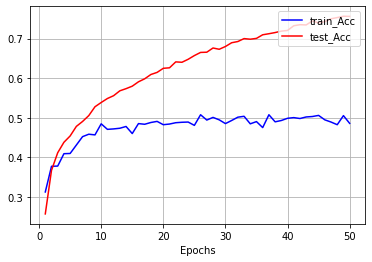

In [48]:
#plot the metrics during training. 
epochs = range(1, (len(Loss_train) + 1))


plt.plot(epochs, Accuracy_train, 'b',label='train_Acc')
plt.plot(epochs, Accuracy_test, 'r',label='test_Acc')


plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=1)
plt.show()

This is the power of neural network, simple archeitecture leads us to good accuracy score of 76%.

Lets, view through lens in which are the class model performs well and worse.

In [59]:
#Making prediction
y_pred=DNN_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)

# true values
y_true=np.argmax(y_test,axis=1)

In [60]:
class_names = lb.classes_

##### CONFUSION MATRIX:

In [57]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('cm.png')
    return ax

Normalized confusion matrix


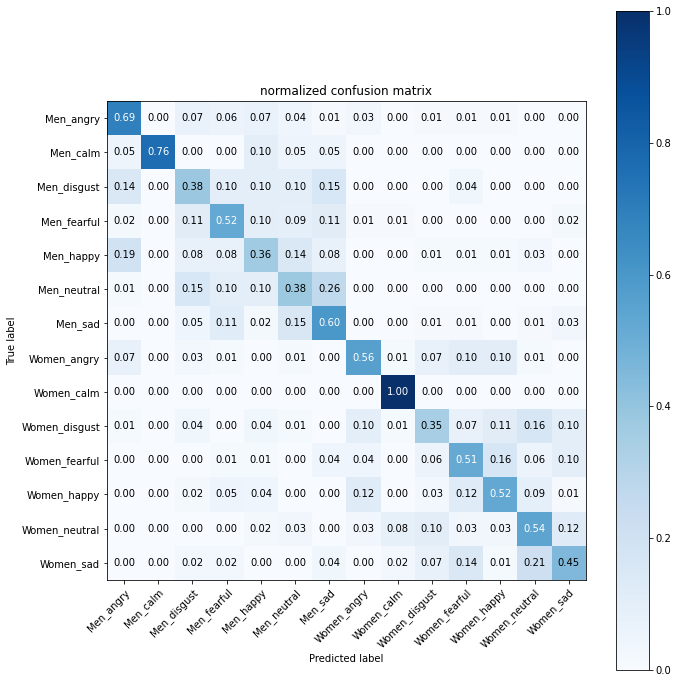

In [61]:
#Defining the class labels
class_names = class_names

# Plotting normalized confusion matrix
confusion_matrix_test = plot_confusion_matrix(y_true, y_pred, classes = class_names, title='normalized confusion matrix',
                                              normalize=True)

##### F1 SCORE:

In [63]:
def F1_Score(y_true, y_pred,class_names):
  test_keys = class_names.tolist()
  test_values = f1_score(y_true, y_pred,average=None).tolist()
  res = {'labels' :test_keys, 'F1_score' : test_values}
  df = pd.DataFrame.from_dict(res)
  fig, ax = plt.subplots(figsize = ( 15 , 7 ))
  ax = sns.barplot(x="labels", y="F1_score", data=df,palette='gist_earth_r')
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

  ax.axhline(y=df['F1_score'].min(), xmin=0.0, xmax=1.0, color='r',)
  ax.set_title( "F1_score_per_class" , size = 24 )
  return ax

<AxesSubplot:title={'center':'F1_score_per_class'}, xlabel='labels', ylabel='F1_score'>

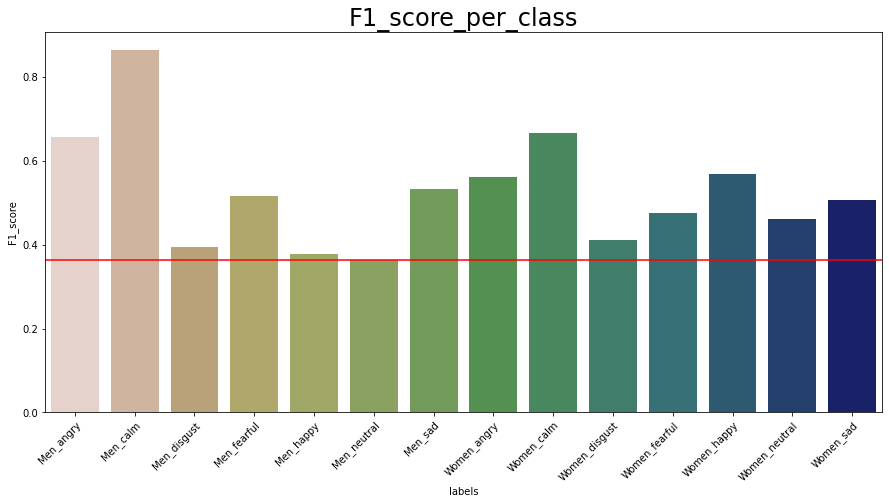

In [64]:
F1_Score(y_true, y_pred,class_names)

By simple model we can acheive descent test accuracy of 50%. 

**PROS OF BASELINE MODEL:**


*   Model classifies gender emotions well.
*   Model having high positive rates over Women_happy, Men_sad, Women_angry, Men_angry.

**NEED:**

Have to increase positive rates over remaining classes too, lets tweak some hyperparametres, in the expect to get better accuracy.

**LIST OF HYPERPARAMETRES:**
  Neural networks has wide varities of hyperparameters, lets categories and prioritize some of them for our use cases.

*   Learning Rate (alpha)
*   Momentum Beta for optimizers like RMS-Prop


*   Minibatch size
*   Number of hidden Layers


*   Number of Neurons per layer
*   Learning rate Decay


*   Regularization

**APPROACH:**


*   Grid Search
*   Random Search


*   Bayesian Optimization

##### HYPERPARAMETRE TUNING:

In [73]:
def DNN_model_tuner(hp):
  
  # parametric space
  num_hidden_layers = hp.Choice('num_hidden_layers', values = [3, 4])
  num_units = hp.Choice('num_units', values = [64, 60, 55, 40 ])
  dropout_rate = hp.Float('dropout_rate', min_value = 0.30, max_value=0.5, step=0.05 )
  learning_rate = hp.Float('learning_rate', min_value = 0.0001, max_value=0.01, sampling='LOG')

  # initiate sequence
  model = tf.keras.models.Sequential()
  # input layer
  model.add(tf.keras.layers.Dense(num_units, input_dim = 32 , activation = 'relu'))

  for i in range(0, num_hidden_layers):
    # fully connected layer
    model.add(tf.keras.layers.Dense(num_units))
    # batch Normalization
    model.add(tf.keras.layers.BatchNormalization())
    # Activation Layer
    model.add(tf.keras.layers.Activation(activation='relu'))
    # Dropout Layer
    model.add(tf.keras.layers.Dropout(dropout_rate))
  # Output Layer
  model.add(tf.keras.layers.Dense(14, activation = 'softmax'))
  # model compliling
  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics = ['accuracy']
  )

  return model

In [74]:
class CustomTuner(keras_tuner.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value=32, max_value=512, step=64)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', min_value=100, max_value=300, step=100)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [75]:
tuner = CustomTuner(
    DNN_model_tuner,
    objective = 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'emotion_recognition',
    overwrite = True
)

In [76]:
tuner.search(
    X_train, y_train,
    validation_data = (X_test, y_test),
    verbose = True
)

Trial 20 Complete [00h 01m 31s]
val_accuracy: 0.3893360197544098

Best val_accuracy So Far: 0.5291750431060791
Total elapsed time: 00h 40m 14s
INFO:tensorflow:Oracle triggered exit


SELECTING TOP 1 MODEL FROM SEARCH SPACE:

In [77]:
tuner.results_summary(1)

Results summary
Results in logs\emotion_recognition
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 60
dropout_rate: 0.39999999999999997
learning_rate: 0.006189539451443283
batch_size: 480
epochs: 200
Score: 0.5291750431060791


In [78]:
# extract best model from search
best_model = tuner.get_best_models(num_models=1)[0]

In [80]:
#Making prediction
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

<AxesSubplot:title={'center':'F1_score_per_class'}, xlabel='labels', ylabel='F1_score'>

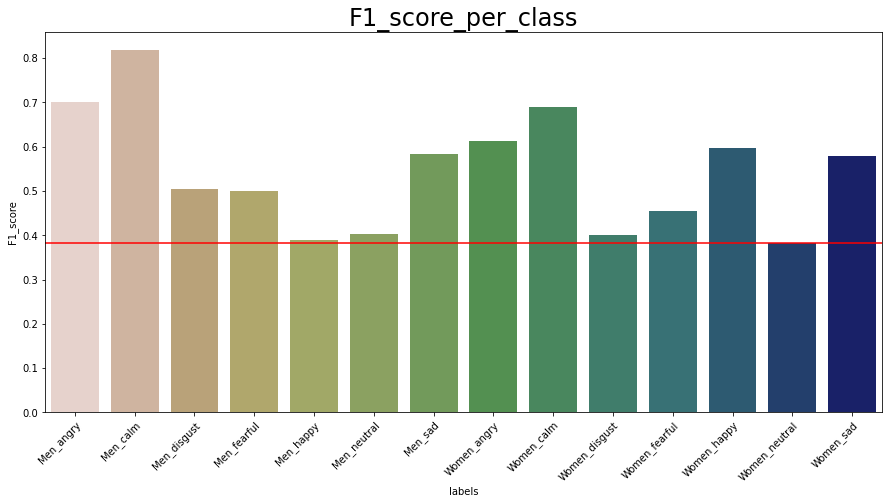

In [82]:
# F1 Score for test data
F1_Score(y_true, y_pred,class_names)


##### 1D CONVOLUTIONAL NEURAL NETWORK:

In [83]:
# converting 2D to 3D tensor
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(7155, 32, 1)

In [92]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[0]

In [101]:
def CNN_1D_Baseline():    
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))

    model.add(Dense(14, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [102]:
CONV1D = CNN_1D_Baseline()

In [103]:
CONV1D.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 30, 64)            256       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 28, 64)            12352     
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               89700     
_________________________________________________________________
dense_14 (Dense)             (None, 14)               

In [104]:
CONV1D.fit(X_train, y_train, epochs=10, batch_size=32,validation_data=(X_test, y_test))

Epoch 1/10
224/224 [==============================] - 8s 22ms/step - loss: 2.1797 - accuracy: 0.2345 - val_loss: 1.9720 - val_accuracy: 0.3048
Epoch 2/10
224/224 [==============================] - 4s 16ms/step - loss: 1.9045 - accuracy: 0.3173 - val_loss: 1.8276 - val_accuracy: 0.3571
Epoch 3/10
224/224 [==============================] - 4s 16ms/step - loss: 1.8147 - accuracy: 0.3458 - val_loss: 1.7137 - val_accuracy: 0.3944
Epoch 4/10
224/224 [==============================] - 4s 17ms/step - loss: 1.7543 - accuracy: 0.3644 - val_loss: 1.6984 - val_accuracy: 0.3873
Epoch 5/10
224/224 [==============================] - 4s 18ms/step - loss: 1.7097 - accuracy: 0.3814 - val_loss: 1.6530 - val_accuracy: 0.4074
Epoch 6/10
224/224 [==============================] - 4s 17ms/step - loss: 1.6616 - accuracy: 0.4024 - val_loss: 1.6123 - val_accuracy: 0.4225
Epoch 7/10
224/224 [==============================] - 4s 17ms/step - loss: 1.6418 - accuracy: 0.4092 - val_loss: 1.5901 - val_accuracy: 0.4235

In [105]:
#Making prediction
y_pred = CONV1D.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

In [106]:
# CNN model using unseen data
loss, accuracy = CONV1D.evaluate(X_test, y_test)

32/32 [==============================] - 0s 8ms/step - loss: 1.5160 - accuracy: 0.4467


<AxesSubplot:title={'center':'F1_score_per_class'}, xlabel='labels', ylabel='F1_score'>

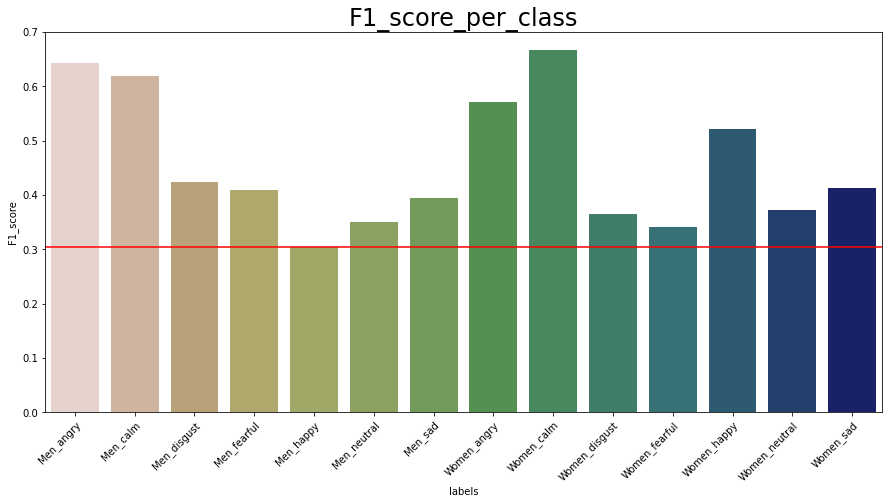

In [107]:
# F1 Score for test data
F1_Score(y_true, y_pred,class_names)